In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import pickle as pk
import numpy as np
import torch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)
dev = torch.device(device)
import torch.optim as optim
import sys, os
# append the root_dir to the path
# sys.path.append(root_dir)
# from nf.combined_models import COMBINED_Model
# from all_models import *
# from utils_data_prep import *
# from combined_models import *
# from tqdm import tqdm
# import pyyaml
# from colossus.cosmology import cosmology
# params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
# cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
# from colossus.lss import mass_function
from tqdm import tqdm

import yaml

import matplotlib.pyplot as pl
import matplotlib.pyplot as pl
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline



cuda


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi



/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
from tqdm import tqdm
import pickle as pk
ldir_stats = '/mnt/home/spandey/ceph/AR_NPE/SAVE_STATS_TEST_CMASS/'
# isim_array = np.arange(0,200)
# isim_array = np.arange(0,430)
isim_array = np.arange(0,1000)
for ji in tqdm(range(len(isim_array))):
    isim = isim_array[ji]
    # saved_j = pk.load(open(ldir_stats + '/saved_stats_halos_' + str(isim) + '_CMASS.pk', 'rb'))
    try:
        saved_j = pk.load(open(ldir_stats + '/saved_stats_halos_with_MASS_WEIGHTED_' + str(isim) + '_CMASS.pk', 'rb'))    

        # saved_j2 = pk.load(open(ldir_stats + '/saved_stats_MASS_WEIGHTED_halos_' + str(isim) + '_CMASS.pk', 'rb'))
        # saved_j['summary_concat_mock_all'] = summary_concat_mock_all
        # saved_j['summary_concat_truth_all'] = summary_concat_truth_all
        # saved_j['cosmo'] = cosmo
        if ji == 0:
            x_all = saved_j['summary_concat_mock_all'][None,:]
            x_all_truth = saved_j['summary_concat_truth_all'][None,:]            

            # x_all = saved_j['summary_concat_mock_all_unweighted_weighted'][None,:]            
            # x_all_truth = saved_j['summary_concat_truth_all_unweighted_weighted'][None,:]                        

            # x_all = saved_j['summary_concat_mock_all_unweighted_weighted'][None,:58]            
            # x_all_truth = saved_j['summary_concat_truth_all_unweighted_weighted'][None,:58]                        


            # x_all2 = saved_j2['summary_concat_mock_all'][None,:]
            # x_all = np.concatenate((x_all1, x_all2), axis = 1)
            theta_all = saved_j['cosmo'][None,:]
        else:
            x_new = saved_j['summary_concat_mock_all'][None,:]
            x_new_truth = saved_j['summary_concat_truth_all'][None,:]            

            # x_new = saved_j['summary_concat_mock_all_unweighted_weighted'][None,:58]            
            # x_new_truth = saved_j['summary_concat_truth_all_unweighted_weighted'][None,:58]                        

            # x_all1 = saved_j['summary_concat_mock_all'][None,:]
            # x_all2 = saved_j2['summary_concat_mock_all'][None,:]
            # x_new = np.concatenate((x_all1, x_all2), axis = 1)

            # x_all = np.concatenate((x_all, saved_j['summary_concat_mock_all'][None,:]), axis = 0)
            x_all = np.concatenate((x_all, x_new), axis = 0)       
            x_all_truth = np.concatenate((x_all_truth, x_new_truth), axis = 0)       
            theta_all = np.concatenate((theta_all, saved_j['cosmo'][None,:]), axis = 0)
        
    except:
        pass




  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1031.89it/s]


(-0.3, 0.3)

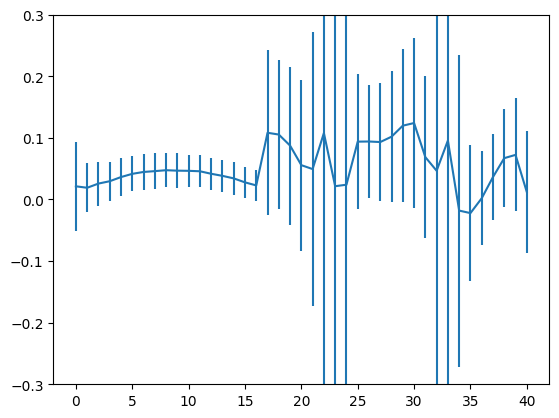

In [49]:
# x_all1.shape, x_all2.shape
# x_all.shape, theta_all.shape
# pl.figure()
x_all_diff = (x_all - x_all_truth)/x_all_truth
x_all_diff_mean = np.mean(x_all_diff, axis = 0)
x_all_diff_std = np.std(x_all_diff, axis = 0)

pl.figure()
pl.errorbar(np.arange(0, x_all_diff_mean.shape[0]), x_all_diff_mean, yerr = x_all_diff_std)
pl.ylim(-0.3, 0.3)




In [26]:
# x_all
len(saved_j['k_Pk'])


17

In [50]:
# x_all.shape, theta_all.shape
# saved_j['summary_concat_mock_all']
x_all_std = np.std(x_all, axis = 0)
x_all_mean = np.mean(x_all, axis = 0)
theta_all_std = np.std(theta_all, axis = 0)
theta_all_mean = np.mean(theta_all, axis = 0)




In [51]:
# x_all = torch.tensor(x_all).float()
# theta_all = torch.tensor(theta_all).float()
x_all = torch.Tensor((x_all - x_all_mean)/x_all_std).float()
theta_all = torch.Tensor((theta_all - theta_all_mean)/theta_all_std).float()




In [52]:
prior = utils.BoxUniform(
    low=(torch.tensor((np.array([0.1, 0.03, 0.5, 0.8, 0.6])  - theta_all_mean)/theta_all_std)), 
    high=torch.tensor(np.array(([0.5, 0.07, 0.9, 1.2, 1.0]) - theta_all_mean)/theta_all_std)
)

neural_posterior = utils.posterior_nn(
    model="maf", hidden_features=8, num_transforms=4
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)




In [53]:
density_estimator = inference.append_simulations(theta_all, x_all).train()
posterior = inference.build_posterior(density_estimator)




 Neural network successfully converged after 359 epochs.

In [54]:
# isim_obs = 510
# saved_j = pk.load(open(ldir_stats + '/saved_stats_halos_' + str(isim_obs) + '_CMASS.pk', 'rb'))
# x_obs = saved_j['summary_concat_truth_all'][None,:]
# theta_obs = saved_j['cosmo'][None,:]

# x_obs = torch.tensor((x_obs - x_all_mean)/x_all_std).float()
# theta_obs = torch.tensor((theta_obs  - theta_all_mean)/theta_all_std).float()




In [55]:
# true_parameter = torch.tensor([0.70, torch.pi / 4])
# x_observed = simulator_model(true_parameter)
# samples = posterior.set_default_x(x_obs).sample((10000,))


In [56]:
# samples.shape
# theta_obs
# theta_obs.cpu().numpy()[0,:]

In [57]:
# import matplotlib.pyplot as pl
# %matplotlib inline
# from getdist import plots, MCSamples
# import getdist
# # Cosmological parameters, fiducial values for prior
# paramnames = ['Om', 'Ob', 'h', 'ns', 'sigma8']
# # paramStr=[r"$\Omega_m$", r"$\Omega_b$",r"$h$",r"$n_s$",r"$\sigma_8$"]
# paramStr=['Om', 'Ob', 'h', 'ns', 'sigma8']

# samples_getdist = MCSamples(samples=samples.cpu().numpy(),names = paramnames, labels = paramStr)
# # Triangle plot
# g = plots.get_subplot_plotter()
# g.triangle_plot(samples_getdist,  markers=theta_obs.cpu().numpy()[0,:])








In [58]:
# theta_obs.shape


In [61]:
isim_obs_array = np.arange(1000, 1100)
# isim_obs_array = np.arange(430, 460)
# isim_obs_array = np.arange(900, 925)

Om_true_all = np.zeros(len(isim_obs_array))
Om_mock_all_mean = np.zeros(len(isim_obs_array))
Om_mock_all_std = np.zeros(len(isim_obs_array))

sig8_true_all = np.zeros(len(isim_obs_array))
sig8_mock_all_mean = np.zeros(len(isim_obs_array))
sig8_mock_all_std = np.zeros(len(isim_obs_array))

for ji in range(len(isim_obs_array)):
    isim_obs = isim_obs_array[ji]

    # saved_j = pk.load(open(ldir_stats + '/saved_stats_halos_' + str(isim_obs) + '_CMASS.pk', 'rb'))
    # x_obs = saved_j['summary_concat_truth_all'][None,:]
        
    saved_j = pk.load(open(ldir_stats + '/saved_stats_halos_with_MASS_WEIGHTED_' + str(isim_obs) + '_CMASS.pk', 'rb'))    
    # x_obs = saved_j['summary_concat_truth_all_unweighted_weighted'][None,:]
    # x_obs = saved_j['summary_concat_truth_all_unweighted_weighted'][None,:58]    
    x_obs = saved_j['summary_concat_truth_all'][None,:]
    theta_obs = saved_j['cosmo'][None,:]

    x_obs = torch.tensor((x_obs - x_all_mean)/x_all_std).float()
    theta_obs = torch.tensor((theta_obs  - theta_all_mean)/theta_all_std).float()

    samples = posterior.set_default_x(x_obs).sample((10000,))

    samples_all = samples.cpu().numpy()

    theta_obs_transformed = (theta_obs.cpu().numpy() * theta_all_std) + theta_all_mean
    Om_true_all[ji] = theta_obs_transformed[0,0]
    sig8_true_all[ji] = theta_obs_transformed[0,4]

    samples_all_transformed = (samples_all * theta_all_std) + theta_all_mean
    Om_mock_all_mean[ji] = np.mean(samples_all_transformed[:,0])
    Om_mock_all_std[ji] = np.std(samples_all_transformed[:,0])

    sig8_mock_all_mean[ji] = np.mean(samples_all_transformed[:,4])
    sig8_mock_all_std[ji] = np.std(samples_all_transformed[:,4])




Drawing 10000 posterior samples: 11128it [00:00, 162895.26it/s]           
Drawing 10000 posterior samples: 11122it [00:00, 203518.34it/s]           
Drawing 10000 posterior samples: 10811it [00:00, 295601.12it/s]           
Drawing 10000 posterior samples: 11828it [00:00, 303098.34it/s]           
Drawing 10000 posterior samples: 12078it [00:00, 287269.37it/s]           
Drawing 10000 posterior samples: 10889it [00:00, 299701.27it/s]           
Drawing 10000 posterior samples: 11234it [00:00, 59465.44it/s]            
Drawing 10000 posterior samples: 11891it [00:00, 176082.43it/s]           
Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples: 10752it [00:00, 28764.12it/s]                          
Drawing 10000 posterior samples: 10294it [00:00, 59240.38it/s]                          
Drawing 10000 posterior samples: 11700it [00:00, 273241.52it/s]           
Drawing 10000 posterior samples: 12004it [00:00, 308016.79it/s]           
Drawing 10000 posterior samples: 10421it [00:00, 91479.56it/s]            
Drawing 10000 posterior samples: 11029it [00:00, 289442.43it/s]           
Drawing 10000 posterior samples: 10836it [00:00, 304400.82it/s]           
Drawing 10000 posterior samples: 11111it [00:00, 272531.65it/s]           
Drawing 10000 posterior samples: 11207it [00:00, 277681.02it/s]           
Drawing 10000 posterior samples: 11676it [00:00, 317004.09it/s]           
Drawing 10000 posterior samples: 10959it [00:00, 299716.21it/s]           
Drawing 10000 posterior samples: 10438it [00:00, 254173.68it/s]           
Drawing 10000 posterior samples: 11139it [00:00, 280205.55it/s]         

Text(0, 0.5, '$\\Omega_m$ inferred')

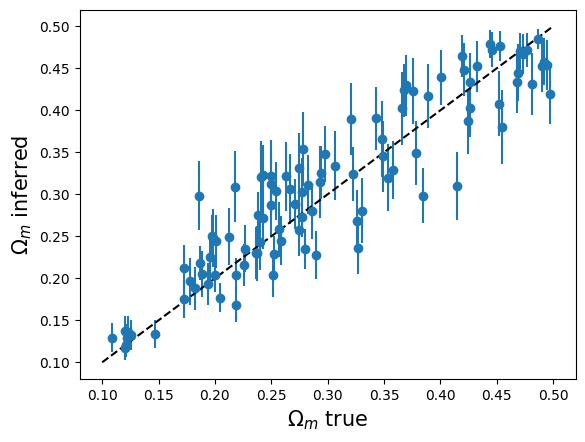

In [62]:
pl.figure()
pl.errorbar(Om_true_all, Om_mock_all_mean, yerr = Om_mock_all_std, fmt = 'o')
pl.plot([0.1, 0.5], [0.1, 0.5], 'k--')
pl.xlabel(r'$\Omega_m$ true', size=15)
pl.ylabel(r'$\Omega_m$ inferred', size=15)




Text(0, 0.5, '$\\sigma_8$ inferred')

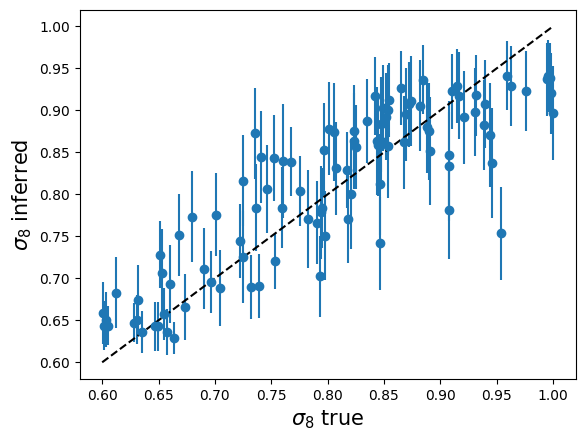

In [63]:
pl.figure()
pl.errorbar(sig8_true_all, sig8_mock_all_mean, yerr = sig8_mock_all_std, fmt = 'o')
pl.plot([0.6, 1.0], [0.6, 1.0], 'k--')
pl.xlabel(r'$\sigma_8$ true', size=15)
pl.ylabel(r'$\sigma_8$ inferred', size=15)




In [64]:
import matplotlib
%matplotlib inline


In [65]:
def get_ranks(
    posterior,
    x: np.array,
    theta: np.array,
    num_samples: int = 20000,
):
    ndim = theta.shape[1]
    ranks = []
    mus, stds = [], []
    trues = []
    for ii in tqdm(range(x.shape[0])):
        try:
            # posterior_samples = sampler.sample(
                # num_samples, x=x[ii])
            posterior_samples = posterior.set_default_x(x[ii,...]).sample((num_samples,))
        except Warning as w:
            # except :
            print("WARNING\n", w)
            continue
        mu, std = posterior_samples.mean(
            axis=0)[:ndim], posterior_samples.std(axis=0)[:ndim]
        rank = [(posterior_samples[:, i].cpu().numpy() < theta[ii, i].cpu().numpy()).sum()
                for i in range(ndim)]
        mus.append(mu.cpu().numpy())
        stds.append(std.cpu().numpy())
        ranks.append(rank)
        trues.append(theta[ii][:ndim].cpu().numpy())
    mus, stds, ranks = np.array(mus), np.array(stds), np.array(ranks)
    trues = np.array(trues)
    return trues, mus, stds, ranks

def plot_ranks_histogram(ranks, nbins=10):
    ncounts = ranks.shape[0] / nbins
    npars = ranks.shape[-1]

    fig, ax = plt.subplots(1, npars, figsize=(npars * 3, 4))
    if npars == 1:
        ax = [ax]

    for i in range(npars):
        ax[i].hist(np.array(ranks)[:, i], bins=nbins)
        # ax[i].set_title(self.labels[i])
        ax[0].set_ylabel('counts')

    for axis in ax:
        axis.set_xlim(0, ranks.max())
        axis.set_xlabel('rank')
        axis.grid(visible=True)
        axis.axhline(ncounts, color='k')
        axis.axhline(ncounts - ncounts ** 0.5, color='k', ls="--")
        axis.axhline(ncounts + ncounts ** 0.5, color='k', ls="--")

def plot_coverage(ranks, plotscatter=True):
    ncounts = ranks.shape[0]
    npars = ranks.shape[-1]

    unicov = [np.sort(np.random.uniform(0, 1, ncounts)) for j in range(20)]

    fig, ax = plt.subplots(1, npars, figsize=(npars * 4, 4))
    if npars == 1:
        ax = [ax]

    for i in range(npars):
        xr = np.sort(ranks[:, i])
        xr = xr / xr[-1]
        cdf = np.arange(xr.size) / xr.size
        if plotscatter:
            for j in range(len(unicov)):
                ax[i].plot(unicov[j], cdf, lw=1, color='gray', alpha=0.2)
        ax[i].plot(xr, cdf, lw=2, label='posterior')
        ax[i].set(adjustable='box', aspect='equal')
        # ax[i].set_title(self.labels[i])
        ax[i].set_xlabel('Predicted Percentile')
        ax[i].legend()

    ax[0].set_ylabel('Empirical Percentile')

    for axis in ax:
        axis.grid(visible=True)


def plot_predictions(trues, mus, stds):
    npars = trues.shape[-1]

    # plot predictions
    fig, axs = plt.subplots(1, npars, figsize=(npars * 4, 4))
    if npars == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    for j in range(npars):
        axs[j].errorbar(trues[:, j], mus[:, j], stds[:, j],
                        fmt="none", elinewidth=0.5, alpha=0.5)

        axs[j].plot(
            *(2 * [np.linspace(min(trues[:, j]), max(trues[:, j]), 10)]),
            'k--', ms=0.2, lw=0.5)
        axs[j].grid(which='both', lw=0.5)
        axs[j].set(adjustable='box', aspect='equal')
        # axs[j].set_title(self.labels[j], fontsize=12)

        axs[j].set_xlabel('True')
        axs[j].set_ylabel('Predicted')


        

In [66]:
# isim_obs_array = np.arange(430, 460)
# isim_obs_array = np.arange(900, 940)
isim_obs_array = np.arange(1000, 1100)

x_test_all = []
theta_test_all = []
for ji in range(len(isim_obs_array)):
    isim_obs = isim_obs_array[ji]

    # saved_j = pk.load(open(ldir_stats + '/saved_stats_halos_' + str(isim_obs) + '_CMASS.pk', 'rb'))
    # x_obs = saved_j['summary_concat_truth_all'][None,:]
        
    saved_j = pk.load(open(ldir_stats + '/saved_stats_halos_with_MASS_WEIGHTED_' + str(isim_obs) + '_CMASS.pk', 'rb'))    
    # x_obs = saved_j['summary_concat_mock_all_unweighted_weighted'][None,:]
    # x_obs = saved_j['summary_concat_truth_all_unweighted_weighted'][None,:]
    # x_obs = saved_j['summary_concat_truth_all_unweighted_weighted'][None,:58]    
    x_obs = saved_j['summary_concat_truth_all'][None,:]

    theta_obs = saved_j['cosmo'][None,:]

    x_obs = torch.tensor((x_obs - x_all_mean)/x_all_std).float()
    theta_obs = torch.tensor((theta_obs  - theta_all_mean)/theta_all_std).float()

    if ji == 0:
        x_test_all = x_obs
        theta_test_all = theta_obs
    else:
        x_test_all = torch.cat((x_test_all, x_obs), dim=0)
        theta_test_all = torch.cat((theta_test_all, theta_obs), dim=0)



In [67]:
trues, mus, stds, ranks = get_ranks(posterior, x_test_all, theta_test_all)




Drawing 20000 posterior samples: 22247it [00:00, 371785.33it/s]           
Drawing 20000 posterior samples: 22269it [00:00, 395162.40it/s]           
Drawing 20000 posterior samples: 21631it [00:00, 91906.80it/s]
Drawing 20000 posterior samples: 20305it [00:00, 225186.59it/s]           
Drawing 20000 posterior samples: 20792it [00:00, 165295.27it/s]
Drawing 20000 posterior samples: 21773it [00:00, 406774.85it/s]           
Drawing 20000 posterior samples: 22554it [00:00, 388175.35it/s]           
Drawing 20000 posterior samples: 20386it [00:00, 303930.54it/s]           
Drawing 20000 posterior samples: 20484it [00:00, 156437.26it/s]                           
Drawing 20000 posterior samples: 20453it [00:00, 134690.45it/s]                           
Drawing 20000 posterior samples: 20256it [00:00, 357532.87it/s]           
Drawing 20000 posterior samples: 20706it [00:00, 272674.14it/s]           
 12%|█▏        | 12/100 [00:01<00:08, 10.32it/s]

Drawing 20000 posterior samples: 20210it [00:00, 74895.44it/s]
Drawing 20000 posterior samples: 22080it [00:00, 214247.58it/s]
Drawing 20000 posterior samples: 21633it [00:00, 355131.46it/s]           
Drawing 20000 posterior samples: 21312it [00:00, 283474.05it/s]           
Drawing 20000 posterior samples: 22391it [00:00, 403883.65it/s]           
Drawing 20000 posterior samples: 20265it [00:00, 351273.18it/s]           
Drawing 20000 posterior samples: 21913it [00:00, 422982.11it/s]           
Drawing 20000 posterior samples: 21140it [00:00, 283310.18it/s]           
Drawing 20000 posterior samples: 22304it [00:00, 406414.71it/s]           
Drawing 20000 posterior samples: 21955it [00:00, 416102.34it/s]           
Drawing 20000 posterior samples: 21624it [00:00, 375084.28it/s]           
Drawing 20000 posterior samples: 21649it [00:00, 374076.11it/s]           
Drawing 20000 posterior samples: 22029it [00:00, 236154.92it/s]           
Drawing 20000 posterior samples: 20483it [00:00,

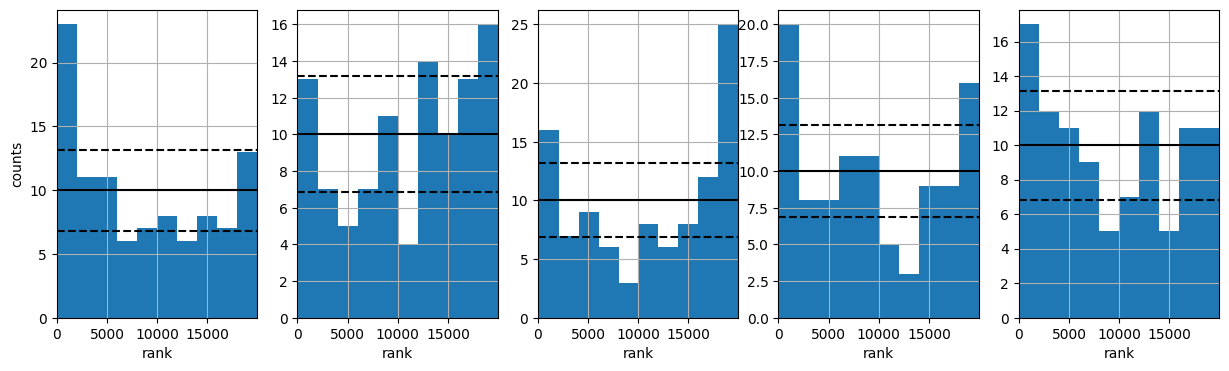

In [68]:
plot_ranks_histogram(ranks)
# plot_coverage(ranks)
# plot_predictions(trues, mus, stds)




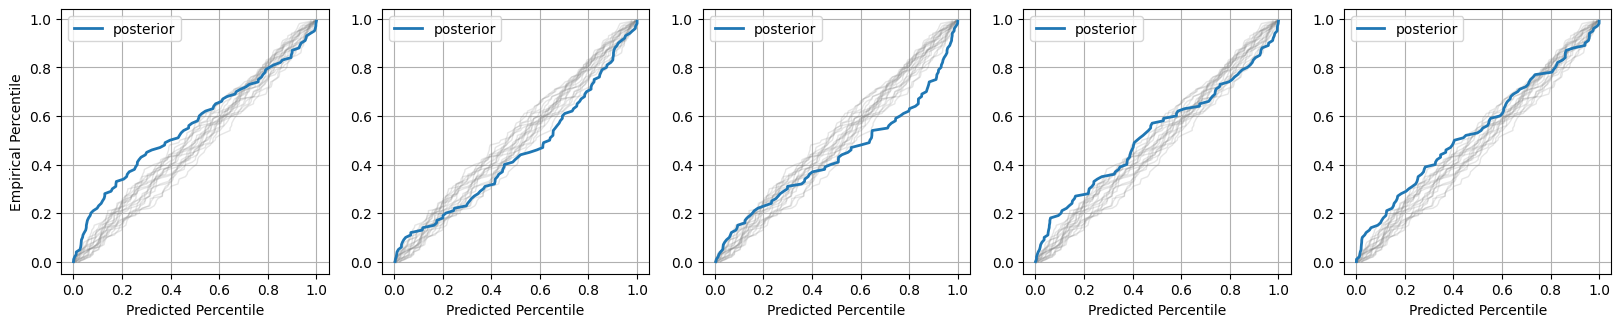

In [69]:
plot_coverage(ranks)


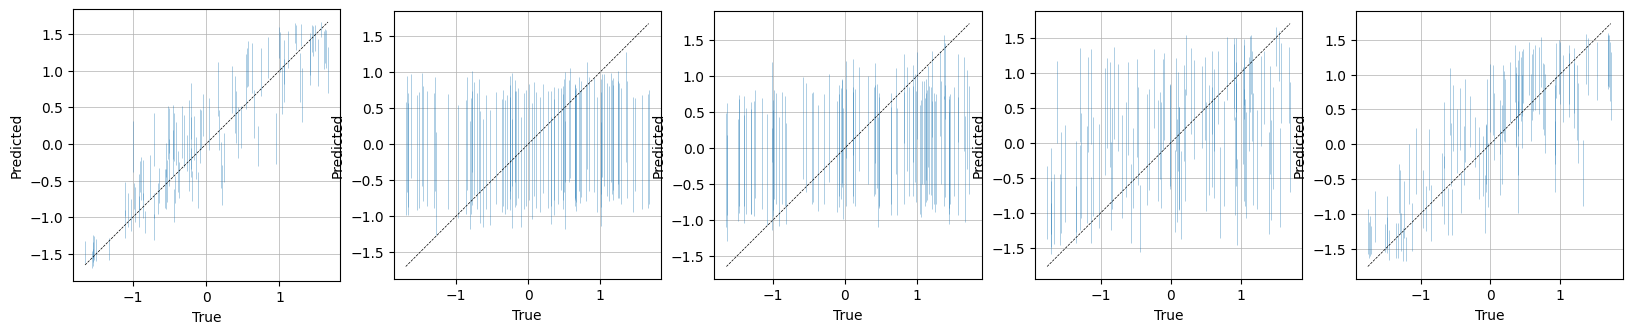

In [70]:
plot_predictions(trues, mus, stds)


